In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colorbar as colorbar
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import matplotlib.animation as animation
import matplotlib as mat
import os
import os.path as op
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm
import seaborn as sea
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from scipy.stats import rayleigh, norm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import savgol_filter
from peregrin.scripts import PlotParams, FilesAndFolders

In [47]:
# INPUT FILE:
input_file = r"Z:\Shared\bryjalab\users\Branislav\Collagen Migration Assay DATA\data 23-7-24\run1\position_4!\C2-position_spots.csv"

# SAVE PATH:
save_path = r"Z:\Shared\bryjalab\users\Branislav\Collagen Migration Assay DATA\data 23-7-24\run1\position_4!\analysed"

In [48]:
title_size = 18
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

# Load the data
df = pd.read_csv(input_file)

In [49]:
unneccessary_float_columns = [ # Definition of unneccesary float columns in the df which are to be convertet to integers
    'ID', 
    'TRACK_ID', 
    'POSITION_T', 
    'FRAME'
    ]
def butter(df, float_columns): # Smoothing the raw dataframe

    # Drop rows with non-numeric values and convert columns to numeric
    df = df.apply(pd.to_numeric, errors='coerce').dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_Z', 'POSITION_T'])

    # Ensure the DataFrame is sorted by TRACK_ID and POSITION_T (time)
    df = df.sort_values(by=['TRACK_ID', 'POSITION_T'])

    # Load the data into a DataFrame
    df = pd.DataFrame(df)    

    # Reset the df index
    df = df.reset_index(drop=True)

    # Reflect y-coordinates around the midpoint
    y_mid = (df['POSITION_Y'].min() + df['POSITION_Y'].max()) / 2
    df['POSITION_Y'] = 2 * y_mid - df['POSITION_Y']

    # Define columns for consistency
    df.columns = [
        'LABEL', 
        'ID', 
        'TRACK_ID', 
        'QUALITY', 
        'POSITION_X', 
        'POSITION_Y', 
        'POSITION_Z', 
        'POSITION_T', 
        'FRAME', 
        'RADIUS', 
        'VISIBILITY', 
        'MANUAL_SPOT_COLOR', 
        'MEAN_INTENSITY_CH1', 
        'MEDIAN_INTENSITY_CH1', 
        'MIN_INTENSITY_CH1', 
        'MAX_INTENSITY_CH1', 
        'TOTAL_INTENSITY_CH1', 
        'STD_INTENSITY_CH1', 
        'EXTRACK_P_STUCK', 
        'EXTRACK_P_DIFFUSIVE', 
        'CONTRAST_CH1', 
        'SNR_CH1'
        ]

    # Drop all NaN values, also drop columns with NaN values
    df = df.dropna(axis=1)

    # Conversion of unnecessary floats to integers
    df[float_columns] = df[float_columns].astype(int)

    return df

In [50]:
def calculate_traveled_distances_for_each_cell_per_frame(df):

    # Calculate distances between consecutive frames
    if df.empty:
            return np.nan
    
    def distance_per_frame(group):
        group = group.copy()
        # Compute the Euclidean distance between consecutive frames
        group['DISTANCE'] = np.sqrt(
            (group['POSITION_X'].diff() ** 2) +
            (group['POSITION_Y'].diff() ** 2)
        )
        return group
    
    # Ensure TRACK_ID is not used as index in grouping; Calculate distances; Drop rows where DISTANCE is NaN (first frame of each TRACK_ID group)
    result_df = df.reset_index(drop=True).groupby('TRACK_ID', as_index=False).apply(distance_per_frame).dropna(subset='DISTANCE')

    return pd.DataFrame(result_df)

In [51]:
def calculate_track_length_traveled_for_each_cell(df):

    # Convert 'Track ID' to numeric (if it's not already)
    df['TRACK_ID'] = pd.to_numeric(df['TRACK_ID'], errors='coerce')
    
    # Making sure that no empty lines are created in the DataFrame
    if df.empty:
        return np.nan
    
    # Sum distances per Track ID
    track_length_per_cell = df.groupby('TRACK_ID')['DISTANCE'].sum().reset_index()

    # Rename columns for clarity
    track_length_per_cell.columns = ['TRACK_ID', 'TRACK_LENGTH']

    # Return the results
    return pd.DataFrame(track_length_per_cell)

In [52]:
def calculate_net_distance_traveled_for_each_cell(df):

    # Convert 'TRACK_ID' to numeric (if it's not already)
    df['TRACK_ID'] = pd.to_numeric(df['TRACK_ID'], errors='coerce')

    # Get the start and end positions for each track, calculate the enclosed distance and group by 'TRACK_ID'
    def calculate_distance(start, end):
        return np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
    
    def net_distance_per_track(track_df):
        if track_df.empty:
            return np.nan
        start_position = track_df.iloc[0][['POSITION_X', 'POSITION_Y']].values
        end_position = track_df.iloc[-1][['POSITION_X', 'POSITION_Y']].values
        return calculate_distance(start_position, end_position)

    net_distances = df.groupby('TRACK_ID').apply(net_distance_per_track).reset_index(name='NET_DISTANCE')

    # Return the results
    return pd.DataFrame(net_distances)

In [53]:
def calculate_confinement_ratio_for_each_cell_and_aggregate_with_track_lengths_net_distances(df):
    # Calculate the confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    Track_stats_df = df[['TRACK_ID','CONFINEMENT_RATIO']]
    return pd.DataFrame(Track_stats_df)

In [54]:
def calculate_distances_per_frame(df):
    min_distance_per_frame = df.groupby('POSITION_T')['DISTANCE'].min().reset_index()
    min_distance_per_frame.rename(columns={'DISTANCE': 'min_DISTANCE'}, inplace=True)
    max_distance_per_frame = df.groupby('POSITION_T')['DISTANCE'].max().reset_index()
    max_distance_per_frame.rename(columns={'DISTANCE': 'max_DISTANCE'}, inplace=True)
    mean_distances_per_frame = df.groupby('POSITION_T')['DISTANCE'].mean().reset_index()
    mean_distances_per_frame.rename(columns={'DISTANCE': 'MEAN_DISTANCE'}, inplace=True)
    std_deviation_distances_per_frame = df.groupby('POSITION_T')['DISTANCE'].std().reset_index()
    std_deviation_distances_per_frame.rename(columns={'DISTANCE': 'STD_DEVIATION_distances'}, inplace=True)
    median_distances_per_frame = df.groupby('POSITION_T')['DISTANCE'].median().reset_index()
    median_distances_per_frame.rename(columns={'DISTANCE': 'MEDIAN_DISTANCE'}, inplace=True)
    merge = pd.merge(min_distance_per_frame, max_distance_per_frame, on='POSITION_T')
    merge = pd.merge(merge, mean_distances_per_frame, on='POSITION_T')
    merge = pd.merge(merge, std_deviation_distances_per_frame, on='POSITION_T')
    merged = pd.merge(merge, median_distances_per_frame, on='POSITION_T')
    return pd.DataFrame(merged)

In [55]:
def calculate_direction_of_travel_for_each_cell_per_frame(df):

    directions = []
    for track_id in df['TRACK_ID'].unique():
        track_data = df[df['TRACK_ID'] == track_id]
        dx = track_data['POSITION_X'].diff().iloc[1:]
        dy = track_data['POSITION_Y'].diff().iloc[1:]
        rad = (np.arctan2(dy, dx))
        for i in range(len(rad)):
            directions.append({
                'TRACK_ID': track_id, 
                'POSITION_T': track_data['POSITION_T'].iloc[i + 1], 
                'DIRECTION_RAD': rad.iloc[i]
                })
    return pd.DataFrame(directions)

In [56]:
def calculate_directions_per_cell(df):
    mean_direction_rad = df.groupby('TRACK_ID')['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = df.groupby('TRACK_ID')['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviatin_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = df.groupby('TRACK_ID')['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    return pd.DataFrame({
        'TRACK_ID': mean_direction_rad.index, 
        'MEAN_DIRECTION_DEG': mean_direction_deg, 
        'STD_DEVIATION_DEG': std_deviatin_deg, 
        'MEDIAN_DIRECTION_DEG': median_direction_deg, 
        'MEAN_DIRECTION_RAD': mean_direction_rad, 
        'STD_DEVIATION_RAD': std_deviation_rad, 
        'MEADIAN_DIRECTION_RAD': median_direction_rad
        }).reset_index(drop=True)

In [57]:
def calculate_absolute_directions_per_frame(df):
    grouped = df.groupby('POSITION_T')
    mean_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviatin_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    return pd.DataFrame({
        'POSITION_T': mean_direction_rad.index, 
        'MEAN_DIRECTION_DEG_abs': mean_direction_deg, 
        'STD_DEVIATION_DEG_abs': std_deviatin_deg, 
        'MEDIAN_DIRECTION_DEG_abs': median_direction_deg, 
        'MEAN_DIRECTION_RAD_abs': mean_direction_rad, 
        'STD_DEVIATION_RAD_abs': std_deviation_rad, 
        'MEADIAN_DIRECTION_RAD_abs': median_direction_rad
        }).reset_index(drop=True)

In [58]:
def calculate_weighted_directions_per_frame(df):
    def weighted_mean_direction(angles, weights):
        weighted_sin = np.average(np.sin(angles), weights=weights)
        weighted_cos = np.average(np.cos(angles), weights=weights)
        return np.arctan2(weighted_sin, weighted_cos)
    
    def weighted_std_deviation(angles, weights, mean_direction_rad):
        weighted_sin = np.average(np.sin(angles - mean_direction_rad), weights=weights)
        weighted_cos = np.average(np.cos(angles - mean_direction_rad), weights=weights)
        return np.sqrt(weighted_sin**2 + weighted_cos**2)
    
    def weighted_median_direction(angles, weights):
        # Weighted median approximation: using percentile function from scipy
        from scipy.stats import cumfreq
        sorted_angles = np.sort(angles)
        sorted_weights = np.array(weights)[np.argsort(angles)]
        cumsum_weights = np.cumsum(sorted_weights)
        midpoint = np.sum(weights) / 2
        idx = np.searchsorted(cumsum_weights, midpoint)
        return sorted_angles[idx]

    grouped = df.groupby('POSITION_T')
    
    # Compute weighted metrics
    mean_direction_rad = grouped.apply(lambda x: weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    
    std_deviation_rad = grouped.apply(lambda x: weighted_std_deviation(x['DIRECTION_RAD'], x['DISTANCE'], weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE']))).reset_index(level=0, drop=True)
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    
    median_direction_rad = grouped.apply(lambda x: weighted_median_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    median_direction_deg = np.degrees(median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'POSITION_T': mean_direction_rad.index,
        'MEAN_DIRECTION_DEG_weight': mean_direction_deg,
        'STD_DEVIATION_DEG_weight': std_deviation_deg,
        'MEDIAN_DIRECTION_DEG_weight': median_direction_deg,
        'MEAN_DIRECTION_RAD_weight': mean_direction_rad,
        'STD_DEVIATION_RAD_weight': std_deviation_rad,
        'MEDIAN_DIRECTION_RAD_weight': median_direction_rad
    }).reset_index(drop=True)

    result_df['POSITION_T'] = result_df['POSITION_T'] + 1
    
    return result_df

In [59]:
def calculate_turn_angles_for_each_cell_per_frame(df):
    # Sort the DataFrame by TRACK_ID and POSITION_T to maintain order
    df = df.sort_values(by=['TRACK_ID', 'POSITION_T'])
    
    # Function to compute the angle difference
    def compute_angle_difference(angles):
        # Compute the difference between consecutive angles
        diff = np.degrees(abs(np.diff(abs(angles))))
        return np.concatenate(([0], diff))  # Return the result with a 0 for the first position

    # Apply the function to each TRACK_ID group
    df['ANGLE_TURNED'] = df.groupby('TRACK_ID')['DIRECTION_RAD'].transform(compute_angle_difference)
    
    df = df[['TRACK_ID', 'POSITION_T', 'ANGLE_TURNED']]

    return df

In [60]:
def calculate_angles_per_frame(df):
    min_angle_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].min().reset_index()
    min_angle_per_frame.rename(columns={'ANGLE_TURNED': 'min_ANGLE_TURNED'}, inplace=True)
    max_angle_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].max().reset_index()
    max_angle_per_frame.rename(columns={'ANGLE_TURNED': 'max_ANGLE_TURNED'}, inplace=True)
    mean_angles_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].mean().reset_index()
    mean_angles_per_frame.rename(columns={'ANGLE_TURNED': 'MEAN_ANGLE_TURNED'}, inplace=True)
    std_deviation_angles_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].std().reset_index()
    std_deviation_angles_per_frame.rename(columns={'ANGLE_TURNED': 'STD_DEVIATION_angles'}, inplace=True)
    median_angles_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].median().reset_index()
    median_angles_per_frame.rename(columns={'ANGLE_TURNED': 'MEDIAN_ANGLE_TURNED'}, inplace=True)
    merge = pd.merge(min_angle_per_frame, max_angle_per_frame, on='POSITION_T')
    merge = pd.merge(merge, mean_angles_per_frame, on='POSITION_T')
    merge = pd.merge(merge, std_deviation_angles_per_frame, on='POSITION_T')
    merged = pd.merge(merge, median_angles_per_frame, on='POSITION_T')
    return pd.DataFrame(merged)

In [61]:
def calculate_number_of_frames_per_cell(spot_stats_df):
    # Count the number of frames for each TRACK_ID in the Spot_stats2_df
    frames_per_track = (spot_stats_df.groupby("TRACK_ID").size().reset_index(name="NUM_FRAMES"))

    return frames_per_track

In [62]:
def radial_gradient(radius, fade_color):
    size = 2 * radius
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt(X**2 + Y**2)
    mask = np.clip(1 - distance, 0, 1)  # Fade out to edges
    
    return mask * fade_color

In [63]:
def calculate_speed(df, variable):

    min_speed_microns_min = df.groupby(variable)['DISTANCE'].min().reset_index()
    min_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MIN'}, inplace=True)
    max_speed_microns_min = df.groupby(variable)['DISTANCE'].max().reset_index()
    max_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MAX'}, inplace=True)
    mean_speed_microns_min = df.groupby(variable)['DISTANCE'].mean().reset_index()
    mean_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEAN'}, inplace=True)
    std_deviation_speed_microns_min = df.groupby(variable)['DISTANCE'].std().reset_index()
    std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_STD_DEVIATION'}, inplace=True)
    median_speed_microns_min = df.groupby(variable)['DISTANCE'].median().reset_index()
    median_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEDIAN'}, inplace=True)
    merge = pd.merge(min_speed_microns_min, max_speed_microns_min, on=variable)
    merge = pd.merge(merge, mean_speed_microns_min, on=variable)
    merge = pd.merge(merge, std_deviation_speed_microns_min, on=variable)
    merged = pd.merge(merge, median_speed_microns_min, on=variable)

    return pd.DataFrame(merged)

In [64]:
butter_df = butter(df, unneccessary_float_columns)
distances_for_each_cell_per_frame_df = calculate_traveled_distances_for_each_cell_per_frame(butter_df) # Call the funciton to clalculate distances for each cell per frame and create the Spot_statistics .csv file
track_lengths_df = calculate_track_length_traveled_for_each_cell(distances_for_each_cell_per_frame_df) # Calling function to calculate the total distance traveled for each cell from the distances_for_each_cell_per_frame_df
net_distances_df = calculate_net_distance_traveled_for_each_cell(distances_for_each_cell_per_frame_df) # Calling function to calculate the net distance traveled for each cell from the distances_for_each_cell_per_frame_df

direction_for_each_cell_per_frame_df = calculate_direction_of_travel_for_each_cell_per_frame(butter_df) # Call the function to calculate direction_for_each_cell_per_frame_df
Spot_stats1_df = pd.merge(distances_for_each_cell_per_frame_df, direction_for_each_cell_per_frame_df, on=['TRACK_ID','POSITION_T'], how='outer') # Merging track_lengths_df and direction_for_each_cell_per_frame_df into Spot_stats_df

turn_angles_for_each_cell_per_frame = calculate_turn_angles_for_each_cell_per_frame(Spot_stats1_df) # Call function to calculate the turn angle for each cell per frame
Spot_stats2_df = pd.merge(Spot_stats1_df, turn_angles_for_each_cell_per_frame, on=['TRACK_ID','POSITION_T'], how='outer') # Merging Spot_stats1_df and turn_angles_for_each_cell_per_frame into Spot_stats2_df DataFrame
Spot_stats2_df.to_csv(op.join(save_path, 'Spot_stats.csv')) # Saving the Spot_stats2_df DataFrame into a newly created .csv file

directions_per_cell_df = calculate_directions_per_cell(direction_for_each_cell_per_frame_df) # Call the function to calculate directions_per_cell_df
frames_per_track = calculate_number_of_frames_per_cell(Spot_stats2_df)
speeds_per_cell = calculate_speed(Spot_stats2_df, 'TRACK_ID')

Track_stats1_df = pd.merge(track_lengths_df, net_distances_df, on='TRACK_ID', how='outer') # Merge the track_lengths_df and the net_distances_df DataFrames into a new DataFrame: Track_stats1_df

confinement_ratio_per_each = calculate_confinement_ratio_for_each_cell_and_aggregate_with_track_lengths_net_distances(Track_stats1_df) # Call the function to calculate confinement ratios from the Track_statistics1_df and write it into the Track_statistics1_df

Track_stats2_df = pd.merge(Track_stats1_df, confinement_ratio_per_each, on='TRACK_ID', how='outer') # Merge the Track_stats1_df and the confinement_ratio_per_each into a new DataFrame: Track_stats2_df
Track_stats3_df = pd.merge(Track_stats2_df, directions_per_cell_df, on='TRACK_ID', how='outer') # Merge the Track_stats2_df and the directions_per_cell_df into a new DataFrame: Track_stats3_df
Track_stats4_df = pd.merge(Track_stats3_df, frames_per_track, on='TRACK_ID', how='outer')
Track_stats5_df = pd.merge(Track_stats4_df, speeds_per_cell, on='TRACK_ID', how='outer')
# print(Track_stats5_df.head())
Track_stats5_df.to_csv((op.join(save_path, 'Track_stats.csv')), index=False) # Save the Track_stats created DataFrame into a newly created Track_stats_debugging.csv file

distances_per_frame_df = calculate_distances_per_frame(distances_for_each_cell_per_frame_df) # Call the function to calculate distances_per_frame_df
absolute_directions_per_frame_df = calculate_absolute_directions_per_frame(direction_for_each_cell_per_frame_df) # Call the function to calculate directions_per_frame_df
weighted_directions_per_frame = calculate_weighted_directions_per_frame(Spot_stats1_df) # Call the function tp calculate weighted_directions_per_frame
angles_per_frame = calculate_angles_per_frame(Spot_stats2_df)
speeds_per_frame = calculate_speed(Spot_stats2_df, 'POSITION_T')

Time_stats1_df = pd.merge(distances_per_frame_df, absolute_directions_per_frame_df, on='POSITION_T', how='outer') # Merge the distances_per_frame_df and the directions_per_frame_df into a new DataFrame: Time_stats1_df
Time_stats2_df = pd.merge(Time_stats1_df, weighted_directions_per_frame, on='POSITION_T', how='outer') # Merging Time_stats1_df and weighted_directions_per_frame
Time_stats3_df = pd.merge(Time_stats2_df, speeds_per_frame, on='POSITION_T', how='outer')
Time_stats3_df.to_csv((op.join(save_path, 'Time_stats.csv')), index=False) # Save the Time_stats1_df into a newly created Time_stats_debugging.csv file


C:\Users\modri\AppData\Local\Temp\ipykernel_22440\2170223756.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.reset_index(drop=True).groupby('TRACK_ID', as_index=False).apply(distance_per_frame).dropna(subset='DISTANCE')
C:\Users\modri\AppData\Local\Temp\ipykernel_22440\3859857744.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df.groupby('TRACK_ID').apply(net_distanc

In [65]:


# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max

In [66]:
def split_dataframe_by_percentiles(df, column_name):
    # Get to know the data frames name
    df_name = [name for name, value in globals().items() if value is df][0]

    # Dictionary to store each DataFrame filtered by percentiles
    dataframes_by_percentile = {}

    # Calculate percentiles and filter the DataFrame for each
    for percentile in range(10, 100, 10):
        threshold_value = df[column_name].quantile(percentile / 100)
        filtered_df = df[df[column_name] > threshold_value]

        # Save the DataFrame
        filename = f'{df_name}_with_{column_name}_thresholded_at_{percentile}th_percentile.csv'
        filtered_df.to_csv(op.join(save_path, filename), index=False)

        # Store in dictionary (optional)
        dataframes_by_percentile[f'threshold_at_{percentile}th_percentile'] = filtered_df

    # Accessing a specific DataFrame for, say, the 30th percentile
    df_thresholded_at_10th_percentile = dataframes_by_percentile['threshold_at_10th_percentile'] # 10th
    df_thresholded_at_20th_percentile = dataframes_by_percentile['threshold_at_20th_percentile'] # 20th
    df_thresholded_at_30th_percentile = dataframes_by_percentile['threshold_at_30th_percentile'] # 30th
    df_thresholded_at_40th_percentile = dataframes_by_percentile['threshold_at_40th_percentile'] # 40th
    df_thresholded_at_50th_percentile = dataframes_by_percentile['threshold_at_50th_percentile'] # 50th
    df_thresholded_at_60th_percentile = dataframes_by_percentile['threshold_at_60th_percentile'] # 60th
    df_thresholded_at_70th_percentile = dataframes_by_percentile['threshold_at_70th_percentile'] # 70th
    df_thresholded_at_80th_percentile = dataframes_by_percentile['threshold_at_80th_percentile'] # 80th
    df_thresholded_at_90th_percentile = dataframes_by_percentile['threshold_at_90th_percentile'] # 90th


    return df_thresholded_at_10th_percentile, df_thresholded_at_20th_percentile, df_thresholded_at_30th_percentile, df_thresholded_at_40th_percentile, df_thresholded_at_50th_percentile, df_thresholded_at_60th_percentile, df_thresholded_at_70th_percentile, df_thresholded_at_80th_percentile, df_thresholded_at_90th_percentile
Track_stats_thresholded_at_10th_percentile, Track_stats_thresholded_at_20th_percentile, Track_stats_thresholded_at_30th_percentile, Track_stats_thresholded_at_40th_percentile, Track_stats_thresholded_at_50th_percentile, Track_stats_thresholded_at_60th_percentile, Track_stats_thresholded_at_70th_percentile, Track_stats_thresholded_at_80th_percentile, Track_stats_thresholded_at_90th_percentile = split_dataframe_by_percentiles(Track_stats3_df, 'NET_DISTANCE')

# You should try: split_dataframe_by_percentiles(df, column_name); column_name = 'NET_DISTANCE', 'TRACK_LENGTH', 'CONFINEMENT_RATIO', 'SPEED_MEDIAN AND OR MEAN, ETC 


<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
C:\Users\modri\AppData\Local\Temp\ipykernel_22440\2648540641.py:94: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)


KeyError: 'CONFINEMENT_RATIO'

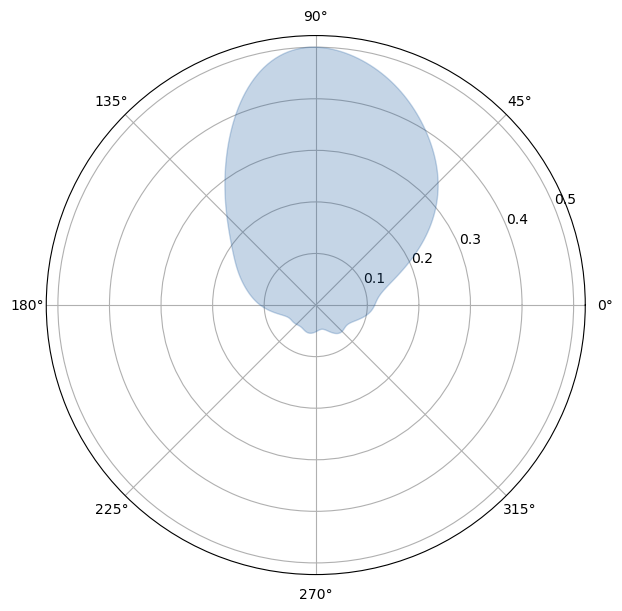

In [67]:
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"]) #303030
cmap_frames = plt.get_cmap('viridis')

def migration_directions_with_kde_plus_mean(df, metric, subject, scaling_metric, cmap_normalization_metric, cmap, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    df_mean_direction = df[metric]

    # Prepare for KDE plot
    x_kde = np.cos(df_mean_direction)
    y_kde = np.sin(df_mean_direction)
    kde = gaussian_kde([x_kde, y_kde])

    # Define the grid for evaluation
    theta_kde = np.linspace(0, 2 * np.pi, 360)
    x_grid = np.cos(theta_kde)
    y_grid = np.sin(theta_kde)

    # Evaluate the KDE on the grid and normalize
    z_kde = kde.evaluate([x_grid, y_grid])
    z_kde = z_kde / z_kde.max() * 0.5  # Normalize to fit within the radial limit

    # Calculate the mean direction
    mean_direction = np.arctan2(np.mean(y_kde), np.mean(x_kde))

    # Start plotting
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'polar': True})

    # Plot KDE
    ax.plot(theta_kde, z_kde, label='Circular KDE', color='None', zorder=5)
    ax.fill(theta_kde, z_kde, alpha=0.25, color='#1b5a9e', zorder=5)

    # Directional Arrows
    scaling_max = df[scaling_metric].max()

    # Normalization of the color map
    if cmap_normalization_metric == None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    else:
        normalization_min = df[cmap_normalization_metric].min()
        normalization_max = df[cmap_normalization_metric].max()
        norm = mcolors.Normalize(vmin=normalization_min, vmax=normalization_max)

    # Row itteration
    for _, row in df.iterrows():
        scaling_metrics = row[scaling_metric]
        mean_direction_rad = row[metric]
        arrow_length = scaling_metrics / scaling_max

        if cmap_normalization_metric == None:
            color = cmap(norm(arrow_length))
        else:
            color = cmap(norm(row[cmap_normalization_metric]))

        if arrow_length == 0:
            continue  # Skip if the arrow length is zero

        # Dynamically adjust the head size based on arrow_length
        scaling_factor = 1 / arrow_length if arrow_length != 0 else 1
        head_width = 0.011 * scaling_factor
        head_length = 0.013

        ax.arrow(mean_direction_rad, 0, 0, arrow_length, color=color, linewidth=0.75, 
                head_width=head_width, head_length=head_length, zorder=4)

    # Plot the dashed line in the mean direction
    ax.plot([mean_direction, mean_direction], [0, 1], linestyle='--', color='darkslateblue', alpha=0.93, linewidth=2.5, zorder=6)

    # Hide the polar plot frame (spines) but keep the grid visible
    ax.spines['polar'].set_visible(False)
    # Customize grid lines (if needed)
    ax.grid(True, 'major', color='#C6C6C6', linestyle='-', linewidth=0.5, zorder=0)

    # Access and customize the radial grid lines
    radial_lines = ax.get_xgridlines()
    for i, line in enumerate(radial_lines):
        if i % 2 == 0:  # Customize every other radial grid line
            line.set_linestyle('--')
            line.set_color('#E6E6E6')
            line.set_linewidth(0.5)

    radial_lines = ax.get_ygridlines()
    for i, line in enumerate(radial_lines):
        line.set_linestyle('--')
        line.set_color('#E6E6E6')
        line.set_linewidth(0.5)

    # Customize the appearance of the polar plot
    ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)
    ax.set_yticklabels([])  # Remove radial labels
    ax.set_xticklabels([])  # Remove angular labels

    # Save the plot
    plt.savefig(op.join(save_path, f'02c_Plot_directions_of_travel_with_mean_and_kernel_density_estimate_{subject}{threshold}.png'), dpi=500)
    # plt.show()
migration_directions_with_kde_plus_mean(Track_stats5_df, 'MEAN_DIRECTION_RAD', 'Cells', 'CONFINEMENT_RATIO', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Time_stats3_df, 'MEAN_DIRECTION_RAD_weight', 'Frames_abs', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None)

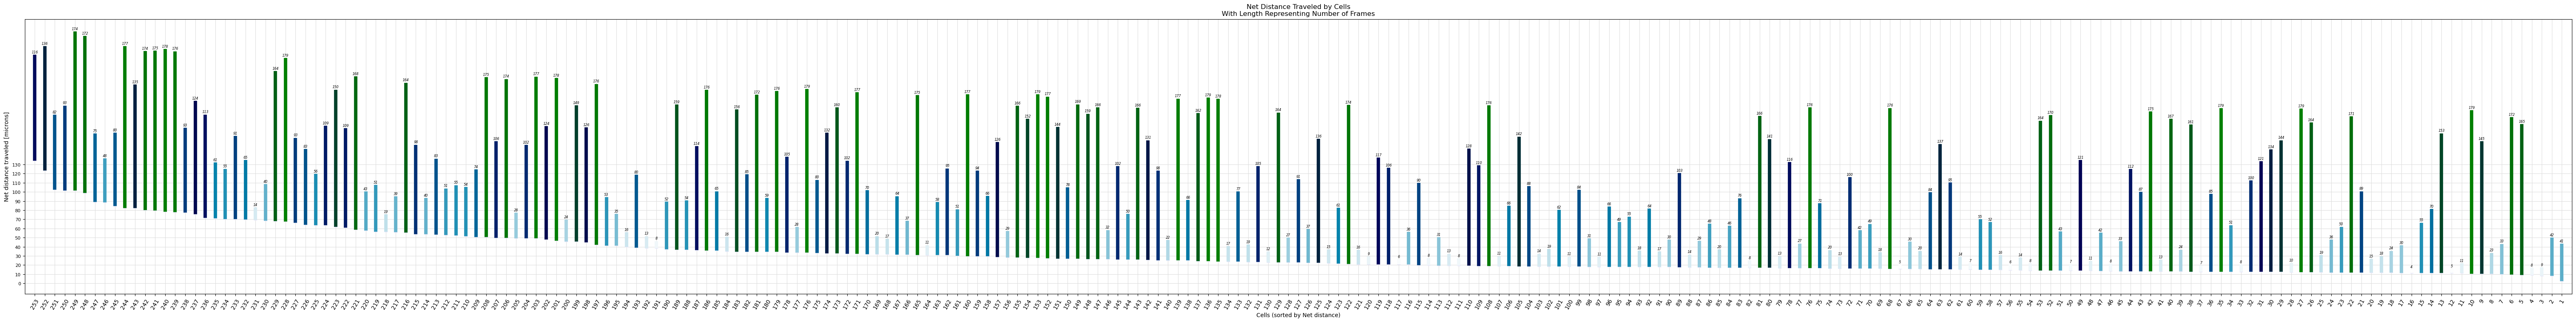

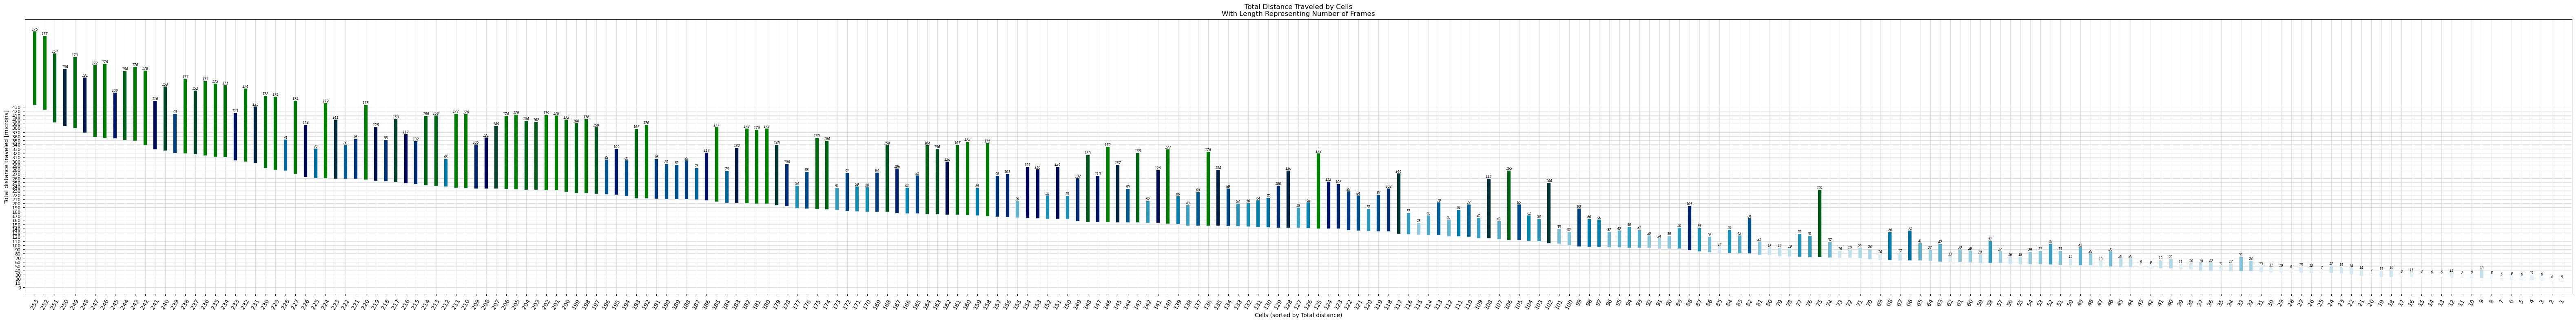

In [ ]:

def histogram_cells_distance(df, metric, str):
    
    # Sort the DataFrame by 'TRACK_LENGTH' in ascending order
    df_sorted = df.sort_values(by=metric)

    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
    df_sorted["Artificial_ID"] = range(1, len(df_sorted) + 1)

    x_span = PlotParams.x_span(df_sorted)

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Loop through each row to plot each cell's data
    for idx, row in df_sorted.iterrows():
        artificial_id = row["Artificial_ID"]
        track_length = row[metric]
        num_frames = row["NUM_FRAMES"]

        # Get the color based on the number of frames using the viridis colormap
        line_color = cmap(norm(num_frames))

        # Plot the "chimney" or vertical line
        ax.vlines(
            x=artificial_id,  # X position for the cell
            ymin=track_length,  # Starting point of the line (y position)
            ymax=track_length + num_frames,  # End point based on number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(artificial_id, track_length, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
        artificial_id,  # X position (same as the chimney)
        track_length + num_frames + 1,  # Y position (slightly above the chimney)
        f"{round(num_frames)}",  # The text to display (formatted mean)
        ha='center',  # Horizontal alignment center
        va='bottom',  # Vertical alignment bottom
        fontsize=6,  # Adjust font size if necessary
        color='black',  # Color of the text
        style='italic'  # Italicize the text
        )

        x = int(row['Artificial_ID'])

        plt.xticks(range(x), rotation=90) # add loads of ticks
        plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)


    max_y = df_sorted[metric].max()
    num_x_values = df_sorted[metric].count()

    # Adjust the plot aesthetics
    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8)
    plt.xticks(range(num_x_values)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    # Set ticks, labels and title
    ax.set_xticks(range(1, num_x_values + 1))
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cells (sorted by {str} distance)")
    ax.set_ylabel(f"{str} distance traveled [microns]")
    ax.set_title(f"{str} Distance Traveled by Cells\nWith Length Representing Number of Frames")

    # Invert x-axis so the highest distance is on the left
    plt.gca().invert_xaxis()

    ax.set_xlim(right=0, left=num_x_values+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig(op.join(save_path, f"02f_Histogram_{str}_distance_traveled_per_cell.png"))
    plt.show()
histogram_cells_distance(Track_stats5_df, 'NET_DISTANCE', 'Net')
histogram_cells_distance(Track_stats5_df, 'TRACK_LENGTH', 'Total')

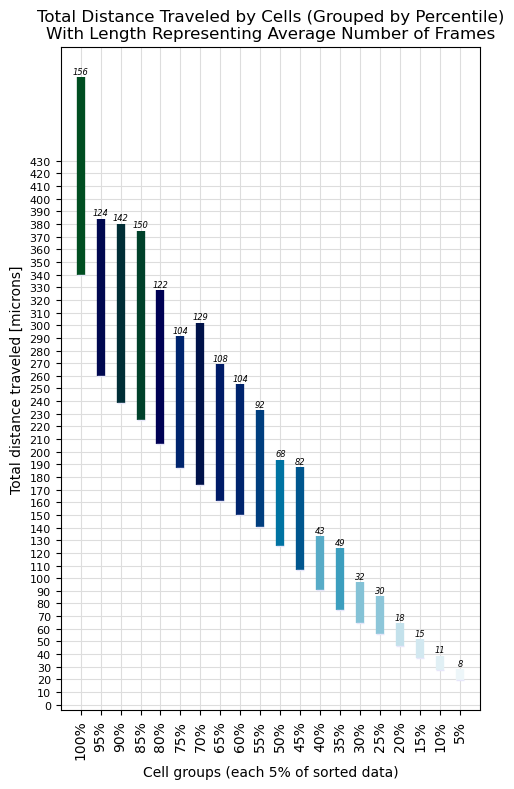

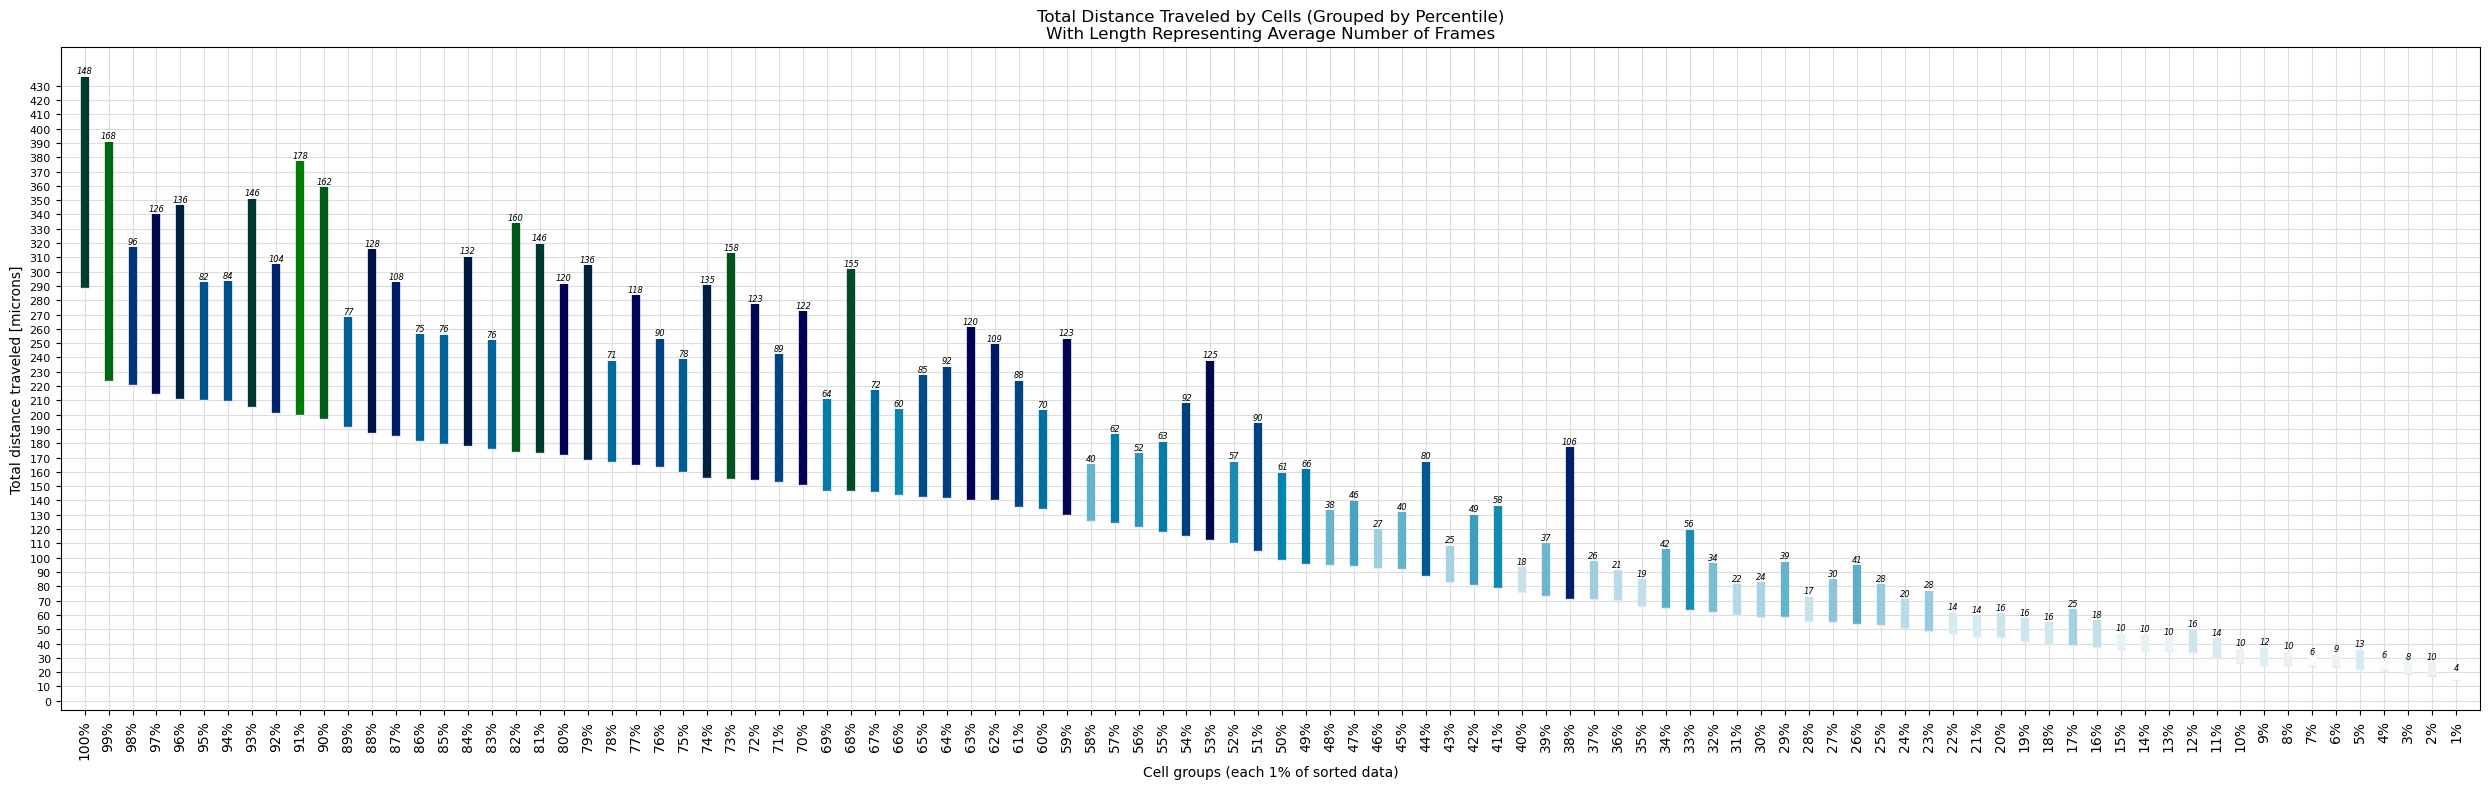

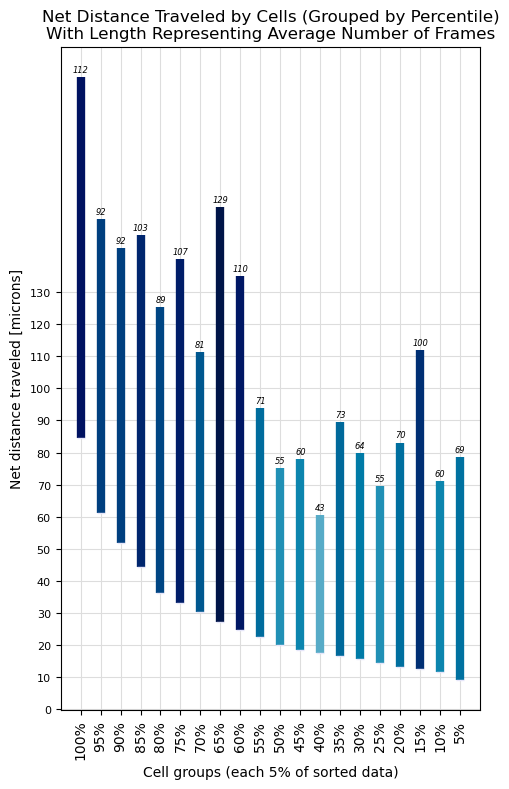

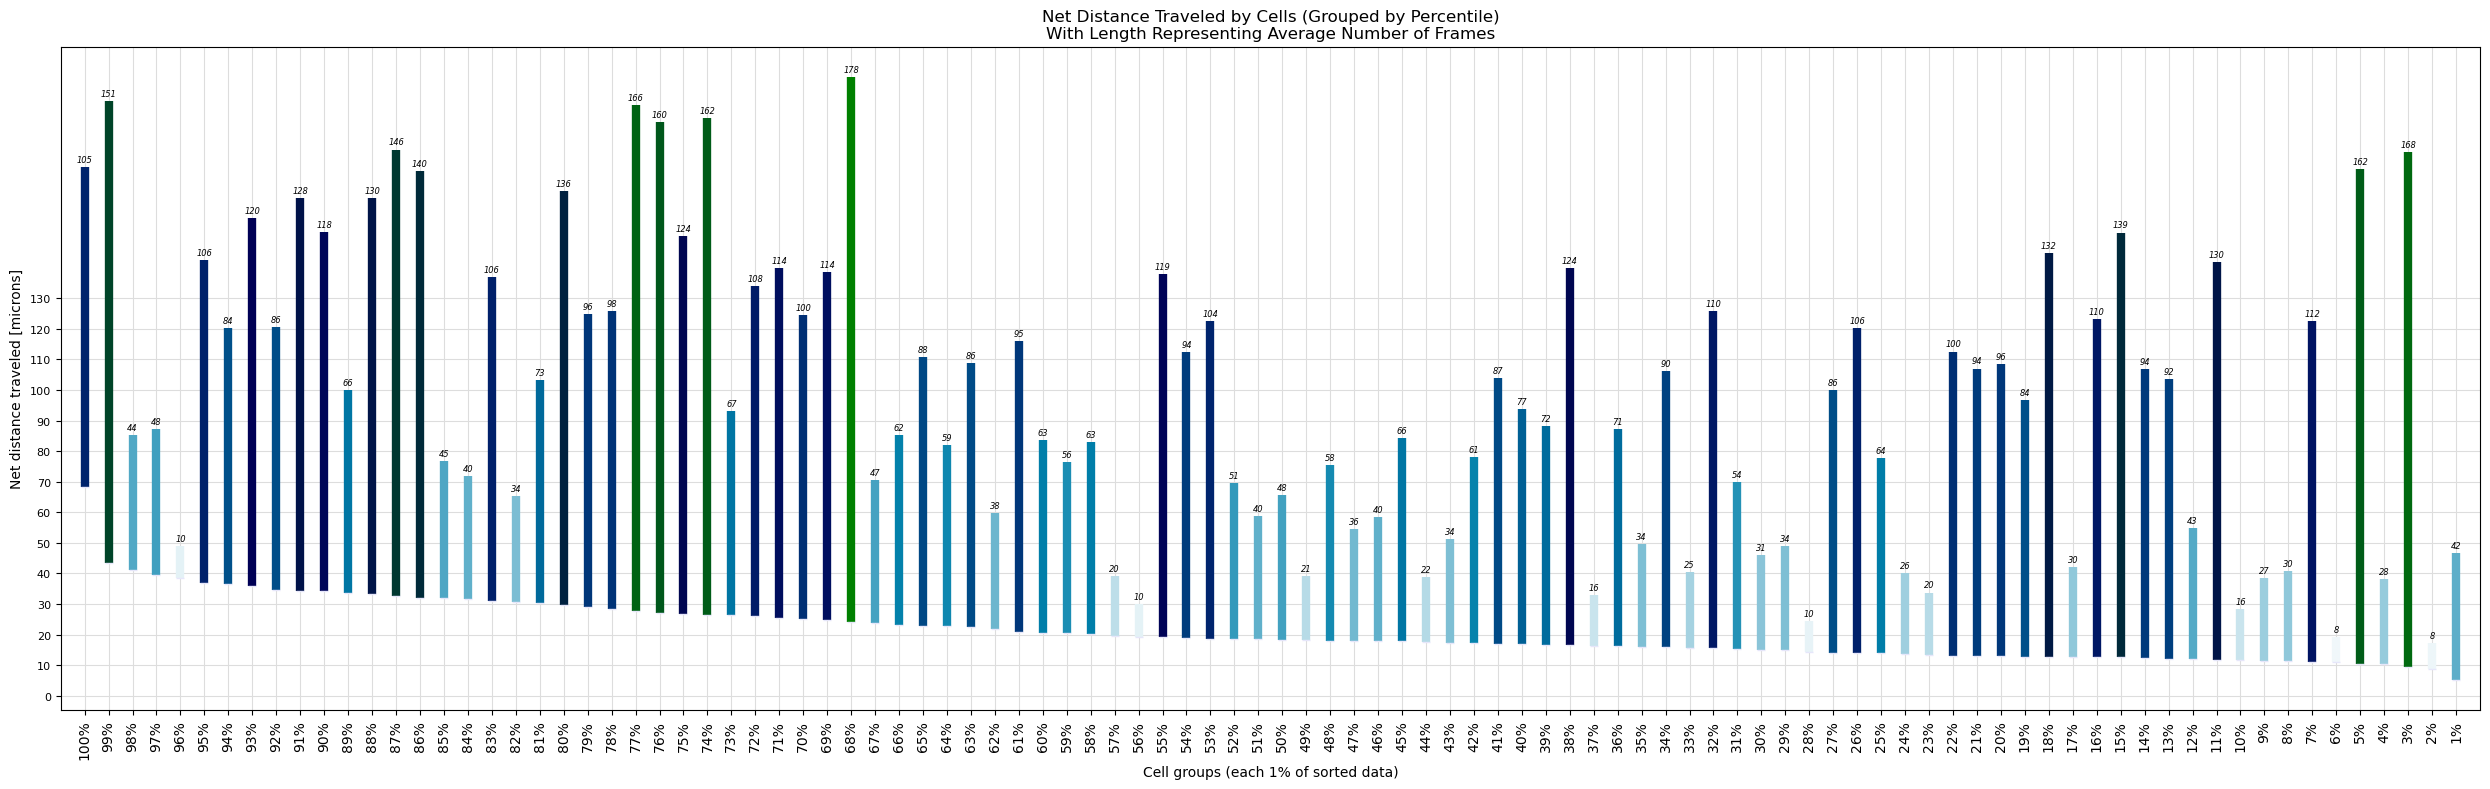

In [ ]:
def histogram_nth_percentile_distance(df, metric, num_groups, percentiles, str, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Sort the DataFrame by 'NET_DISTANCE' in ascending order
    df_sorted = df.sort_values(by=metric)

    # Number of groups (chimneys) and size of each group (5% each)
    group_size = len(df_sorted) // num_groups

    x_span = num_groups * 0.25

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Normalize the 'NUM_FRAMES' column for color mapping
    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Loop over each group and plot the aggregate statistics
    for i in range(num_groups):
        # Define group indices
        group_start = i * group_size
        group_end = (i + 1) * group_size if i != num_groups - 1 else len(df_sorted)

        # Get the current group data
        group_data = df_sorted.iloc[group_start:group_end]

        # Calculate the aggregate statistics for the group
        group_mean_distance = group_data[metric].mean()
        group_mean_frames = group_data["NUM_FRAMES"].mean()

        # Set x-position of the group (e.g., center it based on group index)
        group_x = i + 1

        # Get the color based on the average number of frames in the group
        line_color = cmap(norm(group_mean_frames))

        # Plot the "chimney" representing the group
        ax.vlines(
            x=group_x,  # X position for the group
            ymin=group_mean_distance,  # Starting point of the line (y position)
            ymax=group_mean_distance + group_mean_frames,  # End point based on average number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(group_x, group_mean_distance, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
            group_x,  # X position (same as the chimney)
            group_mean_distance + group_mean_frames + 1,  # Y position (slightly above the chimney)
            f'{round(group_mean_frames)}',  # The text to display (formatted mean)
            ha='center',  # Horizontal alignment center
            va='bottom',  # Vertical alignment bottom
            fontsize=6,  # Adjust font size if necessary
            color='black',  # Color of the text
            style='italic'
            )

    max_y = df_sorted[metric].max() 

    # Adjust the plot aesthetics
    plt.xticks(range(group_x)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8) 

    ax.set_xticks(range(1, num_groups + 1))
    ax.set_xticklabels([f"{percentiles * (i + 1)}%" for i in range(num_groups)], rotation=90)
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cell groups (each {percentiles}% of sorted data)")
    ax.set_ylabel(f"{str} distance traveled [microns]")
    ax.set_title(f"{str} Distance Traveled by Cells (Grouped by Percentile)\nWith Length Representing Average Number of Frames")
    ax.grid(which="major", color="#DDDDDD", linewidth=0.8)
    ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

    # Invert x-axis so the highest distance is on the left
    ax.invert_xaxis()

    ax.set_xlim(right=0, left=num_groups+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig((op.join(save_path, f"02f_Histogram_{str}_distance_traveled_{percentiles}th_percentiles{threshold}.png")))
    plt.show()
histogram_nth_percentile_distance(Track_stats5_df, 'TRACK_LENGTH', 20, 5, 'Total', None)
histogram_nth_percentile_distance(Track_stats5_df, 'TRACK_LENGTH', 100, 1, 'Total', None)
histogram_nth_percentile_distance(Track_stats5_df, 'NET_DISTANCE', 20, 5, 'Net', None)
histogram_nth_percentile_distance(Track_stats5_df, 'NET_DISTANCE', 100, 1, 'Net', None)
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_20th_percentile') # 20th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_20th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_40th_percentile') # 40th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_40th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_60th_percentile') # 60th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_60th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_80th_percentile') # 80th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_80th_percentile')

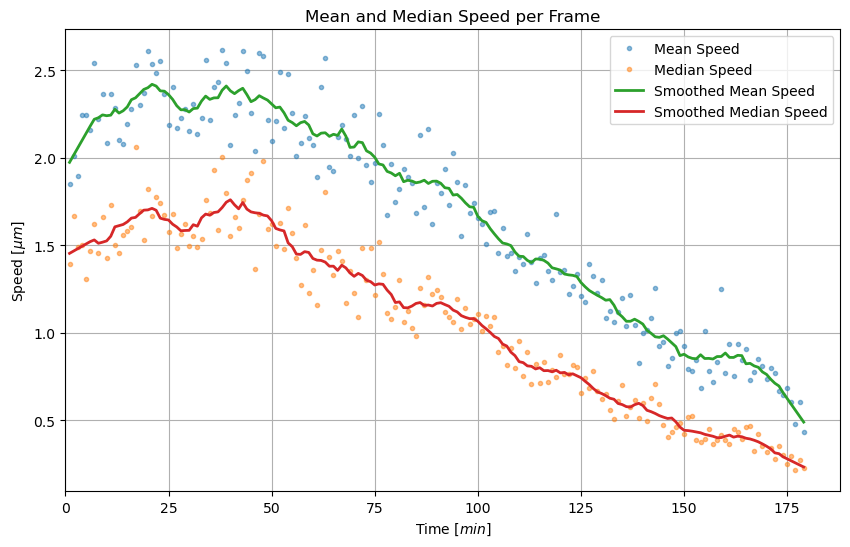

In [ ]:
frames = Time_stats3_df['POSITION_T']
mean_speed = Time_stats3_df['SPEED_MEAN']
median_speed = Time_stats3_df['SPEED_MEDIAN']

# Apply Savitzky-Golay filter for smoothing
mean_speed_smooth = savgol_filter(mean_speed, window_length=11, polyorder=1)
median_speed_smooth = savgol_filter(median_speed, window_length=11, polyorder=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frames, mean_speed, '.', label='Mean Speed', alpha=0.5)
plt.plot(frames, median_speed, '.', label='Median Speed', alpha=0.5)
plt.plot(frames, mean_speed_smooth, '-', label='Smoothed Mean Speed', linewidth=2)
plt.plot(frames, median_speed_smooth, '-', label='Smoothed Median Speed', linewidth=2)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel(r'Time $\it{[min]}$')
plt.ylabel(r'Speed $\it{[μm]}$')
plt.title('Mean and Median Speed per Frame')
plt.legend()
plt.grid(True)
plt.show()

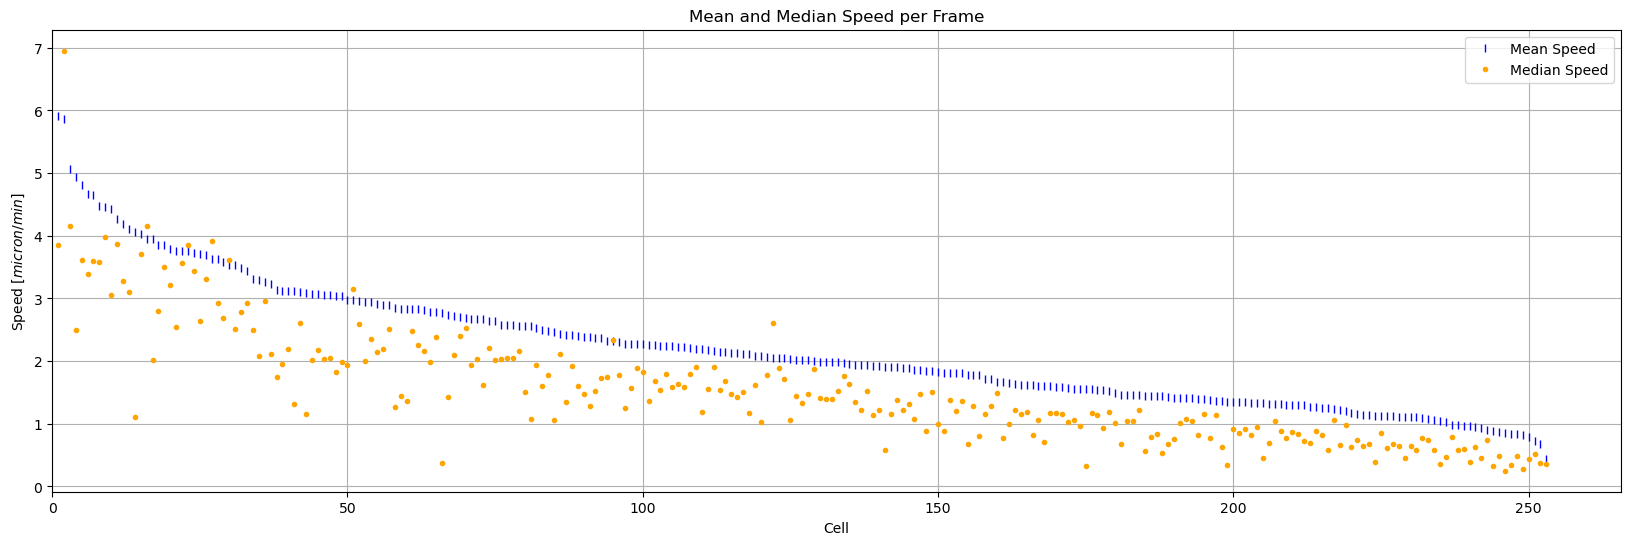

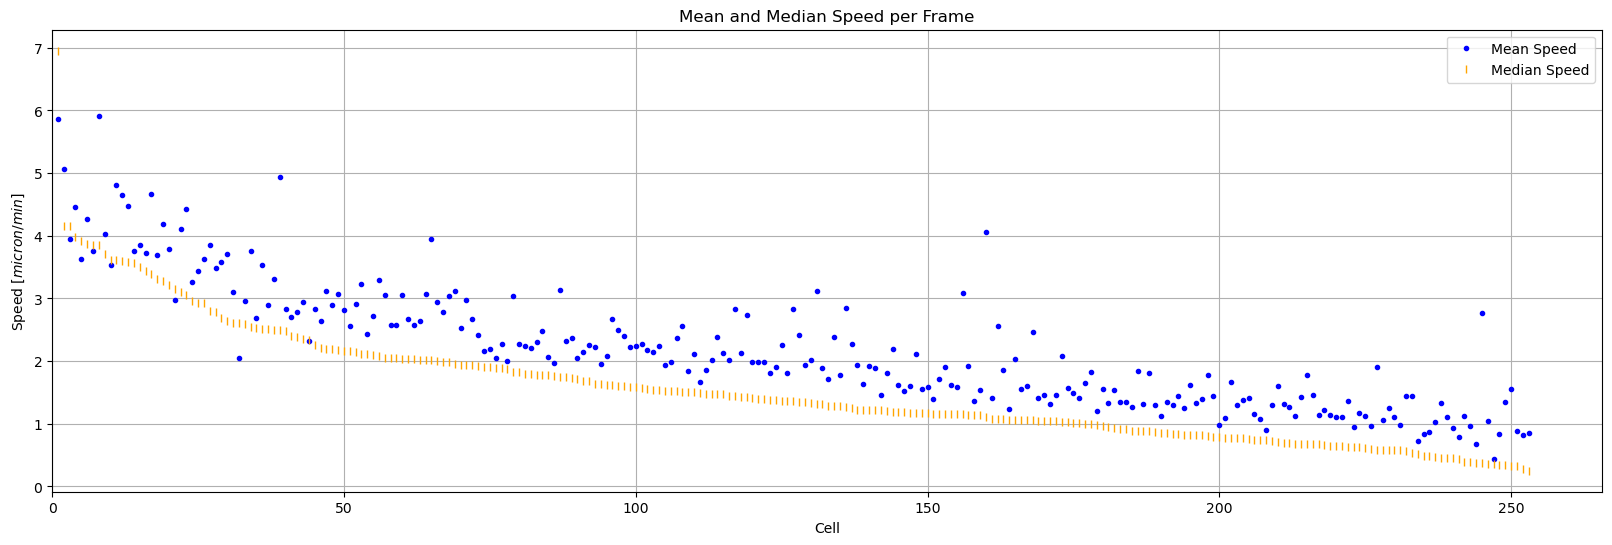

In [ ]:
# Sort the DataFrame by 'TRACK_LENGTH' in ascending order
df_sorted_a = Track_stats5_df.sort_values(by='SPEED_MEAN', ascending=False)
df_sorted_b = Track_stats5_df.sort_values(by='SPEED_MEDIAN', ascending=False)

# Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
df_sorted_a["Artificial_ID"] = range(1, len(df_sorted_a) + 1)
df_sorted_b["Artificial_ID"] = range(1, len(df_sorted_b) + 1)

# defining variables
cell_id_a = df_sorted_a["Artificial_ID"]
mean_speed_a = df_sorted_a['SPEED_MEAN']
median_speed_a = df_sorted_a['SPEED_MEDIAN']

cell_id_b = df_sorted_b["Artificial_ID"]
mean_speed_b = df_sorted_b['SPEED_MEAN']
median_speed_b = df_sorted_b['SPEED_MEDIAN']

# mean_speed_smooth = savgol_filter(mean_speed_a, window_length=11, polyorder=1)
# median_speed_smooth = savgol_filter(median_speed_b, window_length=11, polyorder=1)



x_span = PlotParams.x_span(Track_stats5_df, 0.08)

# Plotting no. 1
plt.figure(figsize=(x_span, 6))
plt.plot(cell_id_a, mean_speed_a, '|', label='Mean Speed', color='blue')
plt.plot(cell_id_a, median_speed_a, '.', label='Median Speed', color='orange')
# plt.plot(cell_id_a, mean_speed_smooth, '-', label='Mean Speed', linewidth=2, color='blue', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[micron/min]}$')
plt.title('Mean and Median Speed per Frame')
plt.legend()
plt.grid(True)
plt.show()


# Plotting no. 2
plt.figure(figsize=(20, 6))
plt.plot(cell_id_b, mean_speed_b, '.', label='Mean Speed', color='blue')
plt.plot(cell_id_b, median_speed_b, '|', label='Median Speed', color='orange')
# plt.plot(cell_id_b, median_speed_smooth, '-', label='Median Speed', linewidth=2, color='orange', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[micron/min]}$')
plt.title('Mean and Median Speed per Frame')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('gainsboro')
    ax.grid(True, which='both', axis='both', color='whitesmoke', linewidth=0.5)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap


TypeError: radial_gradient() got an unexpected keyword argument 'resolution'

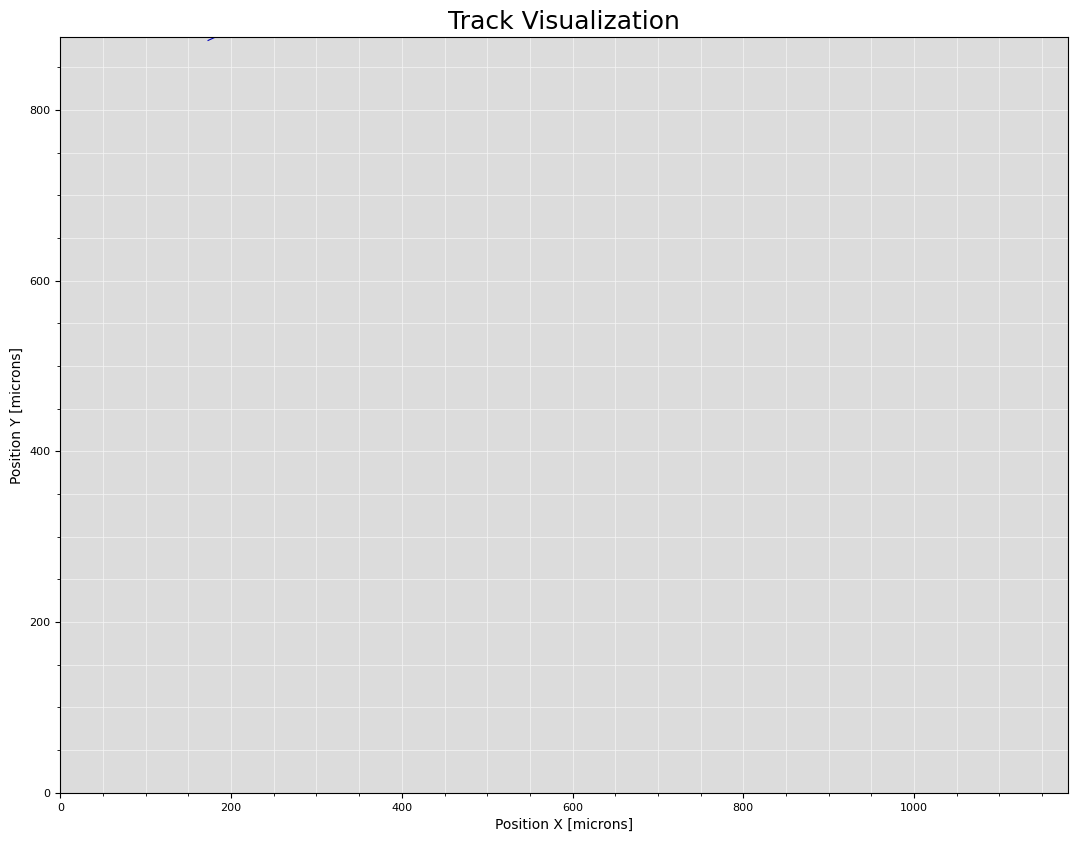

In [ ]:
def visualize_full_tracks(df, df2, threshold):  # Tracks visualization
    # Recognizing the presence of a threshold
    if threshold is None:
        threshold = '_no_threshold'
    else:
        threshold = f'_{threshold}'

    # Using the track_visuals function (assuming it provides fig, ax, track_ids, and track_colors)
    fig, ax, track_ids, track_colors, norm, colormap = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        color = track_colors[track_id]
        ax.plot(x, y, lw=0.8, color=color, label=f'Track {track_id}')

        # Generate a gradient circle at the endpoint if track has more than one point
        if len(x) > 1:
            cmap = mcolors.LinearSegmentedColormap.from_list("", [(color[0], color[1], color[2], 0), color])

            gradient_circle = radial_gradient(resolution=20)

            # Display the gradient at the last track point
            last_x, last_y = x.iloc[-1], y.iloc[-1]
            radius = 45
            extent = (last_x - radius, last_x + radius, last_y - radius, last_y + radius)
            ax.imshow(gradient_circle, extent=extent, origin="lower", cmap=cmap, alpha=0.6)

    plt.savefig(f'01a_Full_tracks_snapshot{threshold}.png')
    plt.show()

# Example call (assuming track_visuals and necessary dataframes are defined)
visualize_full_tracks(df, Track_stats2_df, None)

TypeError: _AxesBase.add_patch() got an unexpected keyword argument 'extent'

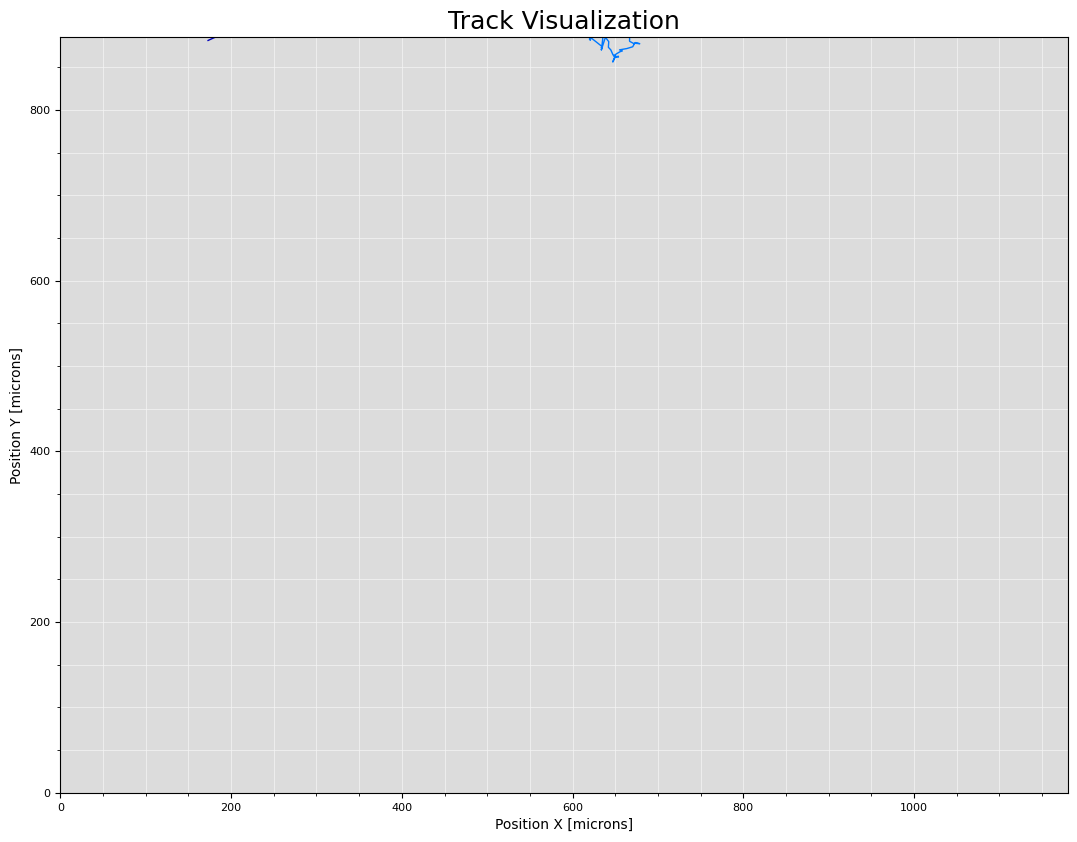

In [ ]:

def visualize_full_tracks(df, df2, threshold):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig, ax, track_ids, track_colors, norm, colormap = track_visuals(df, df2)

    cmap = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"])


    gradient_circle = radial_gradient(50)


    # Plot the full tracks
    for track_id in track_ids:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax.plot(x, y, lw=1, color=track_colors[track_id], label=f'Track {track_id}')
        
        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                radius = 100
                extent = (dx - radius, dx + radius, dy - radius, dy + radius)
                ax.add_patch(gradient_circle, extent=extent, origin="lower", cmap=cmap)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')))
    plt.show()
visualize_full_tracks(df, Track_stats2_df, None)